In [27]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 94 kB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 3.4 MB/s eta 0:00:01
You should consider upgrading via the '/Users/nathvaru/.virtualenvs/py38/bin/python -m pip install --upgrade pip' command.


In [19]:
import pandas as pd
import numpy as np
import os, sys, joblib
import math
import category_encoders as ce
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# GLOBALS
LOCAL_ROOT = "/Users/nathvaru/Documents/personal/MachineHack/HousePricePrediction/"
DATA_DIR = os.path.join(LOCAL_ROOT, 'data')
TRAIN_FN = os.path.join(DATA_DIR, 'Train.csv')
TEST_FN = os.path.join(DATA_DIR, 'Test.csv')
SUBMISSION_FN = os.path.join(DATA_DIR, 'sample_submission.csv')

In [3]:
# read data
df_train = pd.read_csv(TRAIN_FN)
df_test = pd.read_csv(TEST_FN)

print(df_train.shape, '\t', df_test.shape)
print(df_train.head())

(29451, 12) 	 (68720, 11)
  POSTED_BY  UNDER_CONSTRUCTION  RERA  BHK_NO. BHK_OR_RK    SQUARE_FT  \
0     Owner                   0     0        2       BHK  1300.236407   
1    Dealer                   0     0        2       BHK  1275.000000   
2     Owner                   0     0        2       BHK   933.159722   
3     Owner                   0     1        2       BHK   929.921143   
4    Dealer                   1     0        2       BHK   999.009247   

   READY_TO_MOVE  RESALE                      ADDRESS  LONGITUDE   LATITUDE  \
0              1       1        Ksfc Layout,Bangalore  12.969910  77.597960   
1              1       1    Vishweshwara Nagar,Mysore  12.274538  76.644605   
2              1       1             Jigani,Bangalore  12.778033  77.632191   
3              1       1  Sector-1 Vaishali,Ghaziabad  28.642300  77.344500   
4              0       1             New Town,Kolkata  22.592200  88.484911   

   TARGET(PRICE_IN_LACS)  
0                   55.0  
1     

In [4]:
# combine train and test dfs
df_test['TARGET(PRICE_IN_LACS)'] = None
df_test['sample'] = 'test'
df_train['sample'] = 'train'
cols = list(df_test.columns)
df = pd.concat([df_train[cols], df_test[cols]], axis=0)
df.reset_index(drop=True, inplace=True)
df['TARGET(PRICE_IN_LACS)'] = df['TARGET(PRICE_IN_LACS)'].astype(float)

In [5]:
print(df.shape)
print(df['sample'].value_counts())
print(df.head())

(98171, 13)
test     68720
train    29451
Name: sample, dtype: int64
  POSTED_BY  UNDER_CONSTRUCTION  RERA  BHK_NO. BHK_OR_RK    SQUARE_FT  \
0     Owner                   0     0        2       BHK  1300.236407   
1    Dealer                   0     0        2       BHK  1275.000000   
2     Owner                   0     0        2       BHK   933.159722   
3     Owner                   0     1        2       BHK   929.921143   
4    Dealer                   1     0        2       BHK   999.009247   

   READY_TO_MOVE  RESALE                      ADDRESS  LONGITUDE   LATITUDE  \
0              1       1        Ksfc Layout,Bangalore  12.969910  77.597960   
1              1       1    Vishweshwara Nagar,Mysore  12.274538  76.644605   
2              1       1             Jigani,Bangalore  12.778033  77.632191   
3              1       1  Sector-1 Vaishali,Ghaziabad  28.642300  77.344500   
4              0       1             New Town,Kolkata  22.592200  88.484911   

   TARGET(PRICE_I

### Exploration

In [13]:
# util functions
import math

def roundup(x):
    return (round(x/100)) * 100

In [7]:
df.isnull().sum()

POSTED_BY                    0
UNDER_CONSTRUCTION           0
RERA                         0
BHK_NO.                      0
BHK_OR_RK                    0
SQUARE_FT                    0
READY_TO_MOVE                0
RESALE                       0
ADDRESS                      0
LONGITUDE                    0
LATITUDE                     0
TARGET(PRICE_IN_LACS)    68720
sample                       0
dtype: int64

In [7]:
df_train['TARGET(PRICE_IN_LACS)'].describe()

count    29451.000000
mean       142.898746
std        656.880713
min          0.250000
25%         38.000000
50%         62.000000
75%        100.000000
max      30000.000000
Name: TARGET(PRICE_IN_LACS), dtype: float64

In [11]:
cat_cols = ['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'SQUARE_FT',
            'READY_TO_MOVE', 'RESALE']

In [12]:
for col in cat_cols:
    print(col)
    print(df[col].value_counts())
    num_unique_overall = df[col].nunique()
    num_unique_train = df_train[col].nunique()
    print('num_unique_overall: {}; num_unique_train: {}'.format(num_unique_overall,
                                                                num_unique_train))
    print('\n')

POSTED_BY
Dealer     60728
Owner      35458
Builder     1985
Name: POSTED_BY, dtype: int64
num_unique_overall: 3; num_unique_train: 3


UNDER_CONSTRUCTION
0    80744
1    17427
Name: UNDER_CONSTRUCTION, dtype: int64
num_unique_overall: 2; num_unique_train: 2


RERA
0    67056
1    31115
Name: RERA, dtype: int64
num_unique_overall: 2; num_unique_train: 2


BHK_NO.
2     44322
3     35302
1     11957
4      5724
5       584
6       158
7        28
8        25
9        16
12       16
10       12
20       10
11        5
13        4
15        4
16        1
17        1
18        1
31        1
Name: BHK_NO., dtype: int64
num_unique_overall: 19; num_unique_train: 16


BHK_OR_RK
BHK    98089
RK        82
Name: BHK_OR_RK, dtype: int64
num_unique_overall: 2; num_unique_train: 2


SQUARE_FT
1000.000000    1590
1250.000000     982
800.000000      643
1200.000000     612
1600.000000     407
               ... 
910.299003        1
1190.298507       1
2153.030805       1
1438.010105       1
1089.84582

In [22]:
df['sq_ft_rounded'] = df['SQUARE_FT'].apply(roundup)

print(df[['SQUARE_FT', 'sq_ft_rounded']].head())
print(df['sq_ft_rounded'].nunique())
print(df['sq_ft_rounded'].describe())

     SQUARE_FT  sq_ft_rounded
0  1300.236407           1300
1  1275.000000           1300
2   933.159722            900
3   929.921143            900
4   999.009247           1000
443
count    9.817100e+04
mean     7.876968e+03
std      1.050427e+06
min      0.000000e+00
25%      9.000000e+02
50%      1.200000e+03
75%      1.600000e+03
max      2.545455e+08
Name: sq_ft_rounded, dtype: float64


In [24]:
mask = df['sq_ft_rounded'] == 0
print(mask.sum())
print(df.loc[mask, ['SQUARE_FT', 'sq_ft_rounded', 'TARGET(PRICE_IN_LACS)']].head())

34
       SQUARE_FT  sq_ft_rounded  TARGET(PRICE_IN_LACS)
2092    5.000000              0                   45.0
2323   49.800797              0                   30.0
3269    3.000000              0                   12.0
11117  49.000092              0                   16.0
13763   3.985594              0                   24.9


In [25]:
df['location'] = df['ADDRESS'].apply(lambda x: x.split(',')[0].strip().lower())
df['city'] = df['ADDRESS'].apply(lambda x: x.split(',')[-1].strip().lower())

print(df[['ADDRESS', 'location', 'city']].head(20))

                        ADDRESS            location         city
0         Ksfc Layout,Bangalore         ksfc layout    bangalore
1     Vishweshwara Nagar,Mysore  vishweshwara nagar       mysore
2              Jigani,Bangalore              jigani    bangalore
3   Sector-1 Vaishali,Ghaziabad   sector-1 vaishali    ghaziabad
4              New Town,Kolkata            new town      kolkata
5          South Chittoor,Kochi      south chittoor        kochi
6                 Sodala,Jaipur              sodala       jaipur
7                 Kharar,Mohali              kharar       mohali
8         Bileshivale,Bangalore         bileshivale    bangalore
9             Chromepet,Chennai           chromepet      chennai
10     Deshbandhu Para,Siliguri     deshbandhu para     siliguri
11             Hebbal,Bangalore              hebbal    bangalore
12     Garebhavipalya,Bangalore      garebhavipalya    bangalore
13       Sector-119 Noida,Noida    sector-119 noida        noida
14          sanjay nagar,

In [26]:
print(df['location'].nunique())
print(df['city'].nunique())

10775
315


### Preprocessing
0. log transform the target variable and check if outlier treatment is needed
1. Encode POSTED_BY, BHK_OR_RK with labelEncoder
2. Group BHK_NO. - >=7 as one category
3. Round SQUARE_FT to the nearest 10s place
4. Split Address into location and city
5. Raw latitude and longitude values converted to radians
6. Perform clustering on latitude and longitude values and use cluster ids as categorical features
7. Perform clustering on location values and use cluster ids as categorical features

In [53]:
# GLOBAL VARS
DV = 'TARGET(PRICE_IN_LACS)'
DV_TRANS = 'dv_trans'

In [17]:
# transform DV
mask = df['sample'] == 'train'
df.loc[mask, DV_TRANS] = df.loc[mask, DV].apply(lambda x: math.log(x))

print(df[[DV, DV_TRANS]].head())
print(df[DV_TRANS].describe())

   TARGET(PRICE_IN_LACS)  dv_trans
0                   55.0  4.007333
1                   51.0  3.931826
2                   43.0  3.761200
3                   62.5  4.135167
4                   60.5  4.102643
count    29451.000000
mean         4.210367
std          0.899434
min         -1.386294
25%          3.637586
50%          4.127134
75%          4.605170
max         10.308953
Name: dv_trans, dtype: float64


Text(0.5, 1.0, 'Histogram of Log Transformed DV')

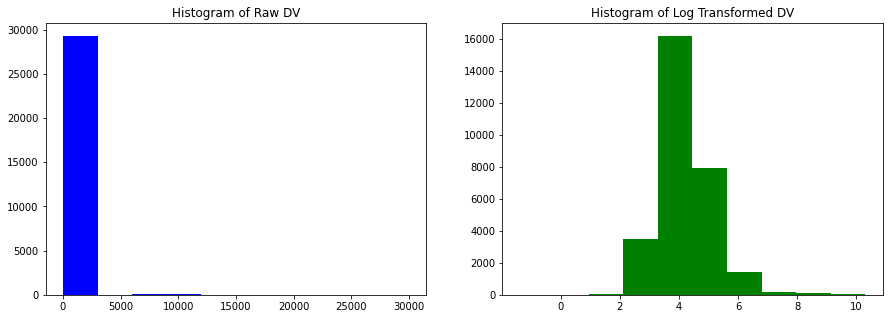

In [28]:
mask = df['sample'] == 'train'
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(x=df.loc[mask, DV], color='blue', label='Raw DV')
#plt.legend()
plt.title('Histogram of Raw DV')

plt.subplot(1, 2, 2)
plt.hist(x=df.loc[mask, DV_TRANS], color='green', label='Log Transformed DV')
#plt.legend()
plt.title('Histogram of Log Transformed DV')

Text(0.5, 1.0, 'Boxplot of Log Transformed DV')

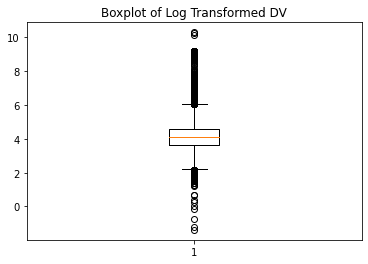

In [30]:
mask = df['sample'] == 'train'
plt.boxplot(x=df.loc[mask, DV_TRANS])
plt.title('Boxplot of Log Transformed DV')

In [31]:
# Encode POSTED_BY, BHK_OR_RK
posted_by_map = {'Dealer': 0, 'Owner': 1, 'Builder': 2}
bhk_or_rk_map = {'BHK': 0, 'RK': 1}

df['POSTED_BY'] = df['POSTED_BY'].apply(lambda x: posted_by_map[x])
df['BHK_OR_RK'] = df['BHK_OR_RK'].apply(lambda x: bhk_or_rk_map[x])

In [37]:
df['BHK_NO.'] = df['BHK_NO.'].apply(lambda x: x if x < 7 else 7)

print(df['BHK_NO.'].value_counts())
mask = df['sample'] == 'train'
print(df.loc[mask, 'BHK_NO.'].value_counts())
print(df.loc[~mask, 'BHK_NO.'].value_counts())

2    44322
3    35302
1    11957
4     5724
5      584
6      158
7      124
Name: BHK_NO., dtype: int64
2    13324
3    10546
1     3574
4     1723
5      190
6       52
7       42
Name: BHK_NO., dtype: int64
2    30998
3    24756
1     8383
4     4001
5      394
6      106
7       82
Name: BHK_NO., dtype: int64


In [38]:
# split address into location and city
df['location'] = df['ADDRESS'].apply(
    lambda x: x.split(',')[0].strip().lower())
df['city'] = df['ADDRESS'].apply(
    lambda x: x.split(',')[-1].strip().lower())

In [40]:
mask = df['sample'] == 'train'
print(df['city'].nunique(), '\t', df.loc[mask, 'city'].nunique(), '\t', df.loc[~mask, 'city'].nunique())

315 	 256 	 293


In [41]:
df['city'].value_counts()

bangalore       14341
lalitpur        10063
pune             6591
mumbai           6539
kolkata          5850
                ...  
tiruchengode        1
faizabad            1
sivasagar           1
nagapattinam        1
nagaur              1
Name: city, Length: 315, dtype: int64

In [48]:
from sklearn.preprocessing import LabelEncoder
le_pipes = []

for col in ['city', 'location']:
    le = LabelEncoder()
    le.fit(df[col].values)

    df[col] = le.transform(df[col].values)
    le_pipes.append((col, le))

In [42]:
# convert latitude and longitude to radians
df['lat_rad'] = np.radians(df['LATITUDE'])
df['long_rad'] = np.radians(df['LONGITUDE'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5, 1.0, 'Elbow Method For Optimal k')

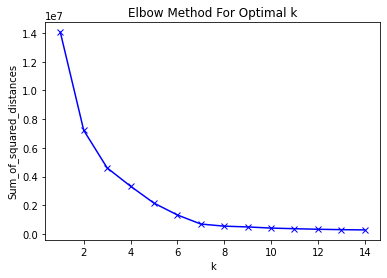

In [44]:
### Clustering
from sklearn.cluster import KMeans

# find optimal number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(df[['LATITUDE', 'LONGITUDE']])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

#### Optimal number of clusters looks to be 8

In [45]:
kmeans = KMeans(8)
clusters = kmeans.fit_predict(df[['LATITUDE', 'LONGITUDE']])
df['lat_long_cluster'] = kmeans.predict(df[['LATITUDE', 'LONGITUDE']])

In [46]:
df['lat_long_cluster'].value_counts()

5    30050
7    25248
0    21849
1    10408
4     9887
6      263
3      234
2      232
Name: lat_long_cluster, dtype: int64

Text(0.5, 1.0, 'Scatterplot of latitude and longitude')

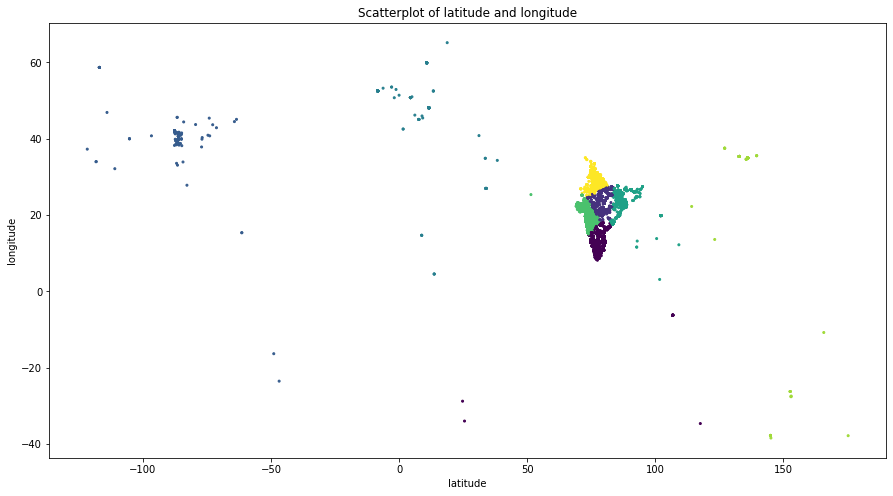

In [47]:
plt.figure(figsize = (15,8))
plt.scatter(df['LATITUDE'], df['LONGITUDE'], s=4, marker='o',
            c=df['lat_long_cluster'])
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Scatterplot of latitude and longitude')

In [50]:
# drop unwanted cols
df.drop(['ADDRESS', 'LATITUDE', 'LONGITUDE'], axis=1, inplace=True)

print(df.columns)

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'TARGET(PRICE_IN_LACS)',
       'sample', 'dv_trans', 'location', 'city', 'lat_rad', 'long_rad',
       'lat_long_cluster'],
      dtype='object')


In [51]:
df.dtypes

POSTED_BY                  int64
UNDER_CONSTRUCTION         int64
RERA                       int64
BHK_NO.                    int64
BHK_OR_RK                  int64
SQUARE_FT                float64
READY_TO_MOVE              int64
RESALE                     int64
TARGET(PRICE_IN_LACS)    float64
sample                    object
dv_trans                 float64
location                   int64
city                       int64
lat_rad                  float64
long_rad                 float64
lat_long_cluster           int32
dtype: object

In [54]:
CAT_COLS = ['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.',
            'BHK_OR_RK', 'READY_TO_MOVE', 'RESALE',
            'location', 'city', 'lat_long_cluster']
NUM_COLS = ['SQUARE_FT', 'lat_rad', 'long_rad']

In [55]:
for cat_var in CAT_COLS:
    for num_var in NUM_COLS:
        for func in ['mean', 'min', 'max', 'nunique']:
            feat_name = '_'.join([func, num_var, 'per', cat_var])
            print(feat_name)
            df[feat_name] = df.groupby([cat_var])[num_var].transform(func)
            print('\n')

mean_SQUARE_FT_per_POSTED_BY


min_SQUARE_FT_per_POSTED_BY


max_SQUARE_FT_per_POSTED_BY


nunique_SQUARE_FT_per_POSTED_BY


mean_lat_rad_per_POSTED_BY


min_lat_rad_per_POSTED_BY


max_lat_rad_per_POSTED_BY


nunique_lat_rad_per_POSTED_BY


mean_long_rad_per_POSTED_BY


min_long_rad_per_POSTED_BY


max_long_rad_per_POSTED_BY


nunique_long_rad_per_POSTED_BY


mean_SQUARE_FT_per_UNDER_CONSTRUCTION


min_SQUARE_FT_per_UNDER_CONSTRUCTION


max_SQUARE_FT_per_UNDER_CONSTRUCTION


nunique_SQUARE_FT_per_UNDER_CONSTRUCTION


mean_lat_rad_per_UNDER_CONSTRUCTION


min_lat_rad_per_UNDER_CONSTRUCTION


max_lat_rad_per_UNDER_CONSTRUCTION


nunique_lat_rad_per_UNDER_CONSTRUCTION


mean_long_rad_per_UNDER_CONSTRUCTION


min_long_rad_per_UNDER_CONSTRUCTION


max_long_rad_per_UNDER_CONSTRUCTION


nunique_long_rad_per_UNDER_CONSTRUCTION


mean_SQUARE_FT_per_RERA


min_SQUARE_FT_per_RERA


max_SQUARE_FT_per_RERA


nunique_SQUARE_FT_per_RERA


mean_lat_rad_per_RERA


min_lat_rad_per_RERA


max_lat_rad_pe

In [57]:
for cat_var in CAT_COLS:
    print(cat_var)
    df[cat_var+'_count'] = df.groupby(cat_var)['lat_rad'].transform('count')

POSTED_BY
UNDER_CONSTRUCTION
RERA
BHK_NO.
BHK_OR_RK
READY_TO_MOVE
RESALE
location
city
lat_long_cluster


In [59]:
print('encoding cat_vars by counting the number/percentage of unique cat_vars\n')            
for cat_var in CAT_COLS:
    for cat_var1 in CAT_COLS:
        if cat_var1 != cat_var:
            feat_name = '_'.join(['nunique', cat_var1, 'per', cat_var])
            print(feat_name)
            df[feat_name] = df.groupby([cat_var])[cat_var1].transform('nunique')
            print('\n')
            feat_name_new = '_'.join(['percunique', cat_var1, 'per', cat_var])
            print(feat_name_new)
            df[feat_name_new] = 1.*df[feat_name]/df[cat_var1].nunique()
            print('\n')
            if df[cat_var1].nunique() == 2:
                for func in ['mean', 'sum']:
                    feat_name = '_'.join([func, cat_var1, 'per', cat_var])
                    print(feat_name)
                    df[feat_name] = df.groupby([cat_var])[cat_var1].transform(func)
                    print('\n')

encoding cat_vars by counting the number/percentage of unique cat_vars

nunique_UNDER_CONSTRUCTION_per_POSTED_BY


percunique_UNDER_CONSTRUCTION_per_POSTED_BY


mean_UNDER_CONSTRUCTION_per_POSTED_BY


sum_UNDER_CONSTRUCTION_per_POSTED_BY


nunique_RERA_per_POSTED_BY


percunique_RERA_per_POSTED_BY


mean_RERA_per_POSTED_BY


sum_RERA_per_POSTED_BY


nunique_BHK_NO._per_POSTED_BY


percunique_BHK_NO._per_POSTED_BY


nunique_BHK_OR_RK_per_POSTED_BY


percunique_BHK_OR_RK_per_POSTED_BY


mean_BHK_OR_RK_per_POSTED_BY


sum_BHK_OR_RK_per_POSTED_BY


nunique_READY_TO_MOVE_per_POSTED_BY


percunique_READY_TO_MOVE_per_POSTED_BY


mean_READY_TO_MOVE_per_POSTED_BY


sum_READY_TO_MOVE_per_POSTED_BY


nunique_RESALE_per_POSTED_BY


percunique_RESALE_per_POSTED_BY


mean_RESALE_per_POSTED_BY


sum_RESALE_per_POSTED_BY


nunique_location_per_POSTED_BY


percunique_location_per_POSTED_BY


nunique_city_per_POSTED_BY


percunique_city_per_POSTED_BY


nunique_lat_long_cluster_per_POSTED_BY


percunique



percunique_lat_long_cluster_per_city


nunique_POSTED_BY_per_lat_long_cluster


percunique_POSTED_BY_per_lat_long_cluster


nunique_UNDER_CONSTRUCTION_per_lat_long_cluster


percunique_UNDER_CONSTRUCTION_per_lat_long_cluster


mean_UNDER_CONSTRUCTION_per_lat_long_cluster


sum_UNDER_CONSTRUCTION_per_lat_long_cluster


nunique_RERA_per_lat_long_cluster


percunique_RERA_per_lat_long_cluster


mean_RERA_per_lat_long_cluster


sum_RERA_per_lat_long_cluster


nunique_BHK_NO._per_lat_long_cluster


percunique_BHK_NO._per_lat_long_cluster


nunique_BHK_OR_RK_per_lat_long_cluster


percunique_BHK_OR_RK_per_lat_long_cluster


mean_BHK_OR_RK_per_lat_long_cluster


sum_BHK_OR_RK_per_lat_long_cluster


nunique_READY_TO_MOVE_per_lat_long_cluster


percunique_READY_TO_MOVE_per_lat_long_cluster


mean_READY_TO_MOVE_per_lat_long_cluster


sum_READY_TO_MOVE_per_lat_long_cluster


nunique_RESALE_per_lat_long_cluster


percunique_RESALE_per_lat_long_cluster


mean_RESALE_per_lat_long_cluster


sum_RES

In [62]:
from itertools import combinations

print('encoding cat_vars interactions by aggregating numeric vars\n')
iter_cat_vars = list(combinations(CAT_COLS, 2))
for f1, f2 in iter_cat_vars:
    for num_var in NUM_COLS:
        for func in ['mean']:
            feat_name = '_'.join([func, num_var, 'per', f1, f2])
            print(feat_name)
            df[feat_name] = df.groupby([f1, f2])[num_var].transform(func)
            print('\n')

encoding cat_vars interactions by aggregating numeric vars

mean_SQUARE_FT_per_POSTED_BY_UNDER_CONSTRUCTION


mean_lat_rad_per_POSTED_BY_UNDER_CONSTRUCTION


mean_long_rad_per_POSTED_BY_UNDER_CONSTRUCTION


mean_SQUARE_FT_per_POSTED_BY_RERA


mean_lat_rad_per_POSTED_BY_RERA


mean_long_rad_per_POSTED_BY_RERA


mean_SQUARE_FT_per_POSTED_BY_BHK_NO.


mean_lat_rad_per_POSTED_BY_BHK_NO.


mean_long_rad_per_POSTED_BY_BHK_NO.


mean_SQUARE_FT_per_POSTED_BY_BHK_OR_RK


mean_lat_rad_per_POSTED_BY_BHK_OR_RK


mean_long_rad_per_POSTED_BY_BHK_OR_RK


mean_SQUARE_FT_per_POSTED_BY_READY_TO_MOVE


mean_lat_rad_per_POSTED_BY_READY_TO_MOVE


mean_long_rad_per_POSTED_BY_READY_TO_MOVE


mean_SQUARE_FT_per_POSTED_BY_RESALE


mean_lat_rad_per_POSTED_BY_RESALE


mean_long_rad_per_POSTED_BY_RESALE


mean_SQUARE_FT_per_POSTED_BY_location


mean_lat_rad_per_POSTED_BY_location


mean_long_rad_per_POSTED_BY_location


mean_SQUARE_FT_per_POSTED_BY_city


mean_lat_rad_per_POSTED_BY_city


mean_long_rad_per_POSTED

In [64]:
def getCountVar(compute_df, count_df, var_name, count_var):
    """
    compute_df : Data frame for which the count encoding should be done
    count_df : Data frame from which the counts should be taken
    var_name : categorical variable for count encoding
    count_var : some other variable from the dataset (used as dummy variable to get count)
    """
    grouped_df = count_df.groupby(var_name, as_index=False)[count_var].agg('count')
    grouped_df.columns = [var_name, "var_count"]
    merged_df = pd.merge(compute_df, grouped_df, how="left", on=var_name)
    merged_df.fillna(-1, inplace=True)
    return list(merged_df["var_count"])


def getDVEncodeVar(compute_df, target_df, var_name, target_var):
    if type(var_name) != type([]):
        var_name = [var_name]
    grouped_df = target_df.groupby(var_name)[target_var].agg(["mean"]).reset_index()
    grouped_df.columns = var_name + ["mean_value"]
    merged_df = pd.merge(compute_df, grouped_df, how="left", on=var_name)
    merged_df.fillna(-1, inplace=True)
    return list(merged_df["mean_value"])


def do_target_encode(train_df, test_df, cols_to_encode, target_col, encode_type, n_splits=3):
        
    kf = KFold(n_splits=n_splits, shuffle=True,
                               random_state=2020)
    for col in cols_to_encode:
        train_enc_values = np.zeros(train_df.shape[0])
        test_enc_values = 0
        for dev_index, val_index in kf.split(train_df):
            new_train_df = train_df[[col, target_col]]
            dev_X, val_X = new_train_df.iloc[dev_index], new_train_df.iloc[val_index]
            
            if encode_type == 'dv':
                train_enc_values[val_index] =  np.array( 
                    getDVEncodeVar(val_X[[col]], dev_X, col, target_col))
                test_enc_values += np.array( 
                    getDVEncodeVar(test_df[[col]], dev_X, col, target_col))
            elif encode_type == 'count':
                train_enc_values[val_index] =  np.array( 
                    getCountVar(val_X[[col]], dev_X, col, target_col))
                test_enc_values += np.array( 
                    getCountVar(test_df[[col]], dev_X, col, target_col))
        
        test_enc_values /= n_splits
        train_df[col + "_{}_enc_{}".format(encode_type, target_col)] = train_enc_values
        test_df[col + "_{}_enc_{}".format(encode_type, target_col)] = test_enc_values
        
    return train_df, test_df

array([dtype('int64'), dtype('float64'), dtype('O'), dtype('int32')],
      dtype=object)